In [93]:
import pandas as pd 
import matplotlib as plt 
import numpy as np 
RANDOM_STATE = 3_07_23

# ***Описание проекта:промышленность*** 
 
 
 ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.Нужно построить модель для предсказания температуры сплава.

 


### Описание этапа обработки

   Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами.Затем из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

   Процесс по шагам:
   1. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ.
   2. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. 
   3. Затем его перемешивают и снова проводят измерения.
   4. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
   5. Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.Финал 



### Описание данных
Данные состоят из файлов, полученных из разных источников:
* data_arc_new.csv — данные об электродах;
* data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
* data_gas_new.csv — данные о продувке сплава газом;
* data_temp_new.csv — результаты измерения температуры;
* data_wire_new.csv — данные о проволочных материалах (объём);
* data_wire_time_new.csv — данные о проволочных материалах (время).


Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## 1. Выгрузим данные и проведем анализ каждого dataframe



### 1.1 data_arc_new

In [94]:
try:
  data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
except:
  data_arc_new = pd.read_csv(r'D:\data_set\project\data_arc_new.csv')

data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Данные об электродах содержат четыре столбца.Время начала нагрева и и конец по каждой итерации, а также активную и реактивную мощность.
Тип данных у времени object,поэтому поменяем на datetime.Добавим как время нагрева дугой. Также активную и реактивную мощность можно заменить полной.
$$
P = \sqrt[]{ S^{2} + Q^{2}}
$$
Где:
- $P$ — полная мощность
- $S$ — активная 
- $Q$ - реактивная 

P.S.

С точки зрения бизнеса и поставленной цели:*"уменьшить потребление электроэнергии"*, было бы более корректно сделать целевую переменную именно *полною мощность*,так как именно она и есть ключевой показатель *потребления  электроэнергии*

Также создадим еще один столбец с работой:
$$
A = t*P
$$ 
Возможно,этот признак повысит точность предсказания модели,посмотрим позже на практике.

In [95]:
from datetime import timedelta, datetime
# меняем тип данных
data_arc_new[['Начало нагрева дугой','Конец нагрева дугой']] = data_arc_new[['Начало нагрева дугой','Конец нагрева дугой']].apply(pd.to_datetime)
# находим продолжительность и сразу переводим в  секунды,что бы модель могла работать 
data_arc_new['heating_duration'] = data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']
data_arc_new['heating_duration'] = data_arc_new['heating_duration'].dt.total_seconds()
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
 5   heating_duration      14876 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 697.4 KB


In [96]:
data_arc_new

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heating_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157.0
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180.0
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184.0
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57.0


In [97]:
#считаем полную мощность 
data_arc_new['full_power'] = (data_arc_new['Активная мощность']**2 + data_arc_new['Реактивная мощность']**2)**0.5
#считаем работу 
data_arc_new['physical_work'] = data_arc_new['full_power'] * data_arc_new['heating_duration']
data_arc_new


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heating_duration,full_power,physical_work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,159.830252
...,...,...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157.0,0.532085,83.537345
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180.0,0.792429,142.637202
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184.0,1.293389,237.983620
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57.0,0.641792,36.582120


In [98]:
#проверяем корректность данных 
(data_arc_new['heating_duration']<0).sum()	

0

In [99]:
data_arc_new.describe()

,key,Активная мощность,Реактивная мощность,heating_duration,full_power,physical_work
count,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986,171.670946,0.871425,146.879972
std,934.571502,0.258885,5.873485,98.186803,5.868339,646.540055
min,1.000000,0.223120,-715.479924,11.000000,0.275718,6.409531
25%,806.000000,0.467115,0.337175,107.000000,0.578847,71.158372
50%,1617.000000,0.599587,0.441639,147.000000,0.746591,114.486341
75%,2429.000000,0.830070,0.608201,214.000000,1.030427,181.366353
max,3241.000000,1.463773,1.270284,907.000000,715.480272,77987.349613


Как видно из таблицы describe есть незначительные выбросы,поэтом отрежем до 1 квантиля по Реактивная мощность и с 98,по продолжительности нагрева. 

In [100]:
# создадим маску 
mask   = ((data_arc_new['Реактивная мощность']> data_arc_new['Реактивная мощность'].quantile(.01))
          &(data_arc_new['heating_duration']< data_arc_new['heating_duration'].quantile(.98))
)
#перезапишим  переменную 
data_arc_new = data_arc_new[mask]

In [101]:
# перепроверим 
display(data_arc_new.head(5))
data_arc_new.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heating_duration,full_power,physical_work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,159.830252


,key,Активная мощность,Реактивная мощность,heating_duration,full_power,physical_work
count,14433.000000,14433.000000,14433.000000,14433.000000,14433.000000,14433.000000
mean,1614.296266,0.666681,0.490282,164.409963,0.828431,136.481988
std,934.660339,0.257171,0.196201,83.909001,0.321207,91.317888
min,1.000000,0.228605,0.193668,11.000000,0.302847,6.409531
25%,805.000000,0.469847,0.340005,106.000000,0.582534,71.175962
50%,1613.000000,0.602912,0.444286,145.000000,0.751902,113.418020
75%,2429.000000,0.832701,0.610394,209.000000,1.033709,176.518286
max,3241.000000,1.463773,1.270284,444.000000,1.898158,718.597833


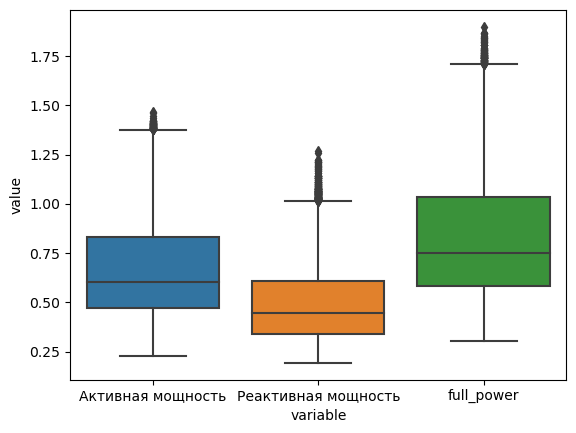

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

df = data_arc_new[['Активная мощность','Реактивная мощность','full_power']]
df_melted = pd.melt(df)
sns.boxplot(x='variable', y='value', data=df_melted) 
plt.show()

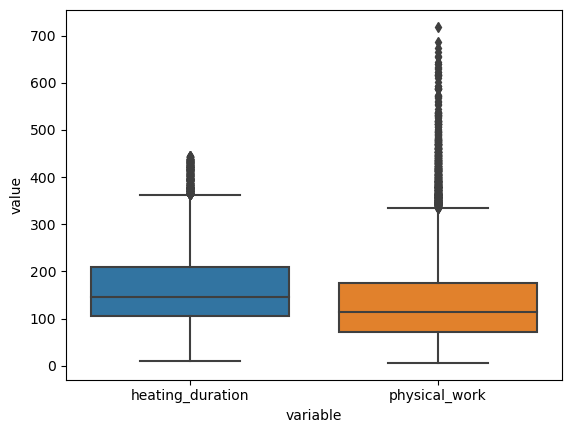

In [103]:
df = data_arc_new[['heating_duration','physical_work']]
df_melted = pd.melt(df)
sns.boxplot(x='variable', y='value', data=df_melted) 
plt.show()

Как видно из диаграмм размаха,для мощностей сильных выбросов нет.Однако есть хвост для физической работы,скорей всего это связано с тем,что выбросы в во времени нагрева умножились на некоторые выбросы из полной мощности;отскалировались.Теперь посмотрим на распределения показаний  

In [104]:
#смотрим пропуски 
data_arc_new.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
heating_duration        0
full_power              0
physical_work           0
dtype: int64

пропусков нет!


Важно отметить,что объектом в нашем проекте служит не одна строка таблицы,а ковш с металлом, который помечен маркером *key*.По скольку эта таблица отражает затраченную мощность,то для наглядность ее можно представить виде суммы значений по ковшу. 

In [105]:
data_arc_group = data_arc_new.groupby('key')[['full_power','physical_work','heating_duration',
                             'Активная мощность','Реактивная мощность']].sum()
data_arc_group


,full_power,physical_work,heating_duration,Активная мощность,Реактивная мощность
key,,,,,
1,3.718736,770.282114,1098.0,3.036730,2.142821
2,2.588349,481.760005,811.0,2.139408,1.453357
3,5.019223,722.837668,655.0,4.063641,2.937457
4,3.400038,683.455597,741.0,2.706489,2.056992
5,2.816980,512.169934,869.0,2.252950,1.687991
...,...,...,...,...,...
3237,2.968351,564.161489,674.0,2.318752,1.852459
3238,1.400614,200.371587,281.0,1.115039,0.845616
3239,6.014480,941.538764,1216.0,4.848005,3.541541


In [106]:
data_arc_group.columns 

Index(['full_power', 'physical_work', 'heating_duration', 'Активная мощность',
       'Реактивная мощность'],
      dtype='object')

In [107]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=5)

for i, col in enumerate(data_arc_group.columns):
    fig.add_trace(
        go.Histogram(x=data_arc_group[col], name=col),
        row=int(i/5)+1, col=i%5+1
    )
  
fig.update_layout(
  title_text='Гистограммы')
fig.show()

Судя по гистограммам данные распределены нормально,есть небольшие выбросы справа.В дальнейшем их следует убрать.

### 1.2 data_bulk_new & data_bulk_time_new


In [108]:
try:
  data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
except:
  data_bulk_new = pd.read_csv(r'D:\data_set\project\data_bulk_new.csv')

data_bulk_new.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [109]:
try:
  data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
except:
  data_bulk_time_new = pd.read_csv(r'D:\data_set\project\data_bulk_time_new.csv')

data_bulk_time_new.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


Начнем с данных о подаче сыпучих материалов **(время)**, это таблица не добавляет к нашей модели никакой информации,ее можно исключить. Но,так же поскольку для разных 'Bulk' порядок разный возможно порядок важен для конечной температуры. Нужно уточнить у специалиста,насколько порядок критичен. 

In [110]:
Bulk = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15']

data_bulk_time_new[Bulk]= data_bulk_time_new[Bulk].apply(pd.to_datetime)
#data_bulk_time_new.info()
#data_bulk_time_new[Bulk] =data_bulk_time_new[Bulk].rank(axis=1)
data_bulk_time_new[Bulk].head(10)

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47
5,NaT,NaT,NaT,2019-05-03 13:57:27,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:48:52,NaT,2019-05-03 14:09:42,2019-05-03 14:03:15
6,NaT,NaT,NaT,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:41:26,NaT,2019-05-03 14:30:50,2019-05-03 14:27:16
7,NaT,NaT,NaT,2019-05-03 15:17:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 15:17:58,NaT,2019-05-03 15:13:18,2019-05-03 15:05:33
8,NaT,NaT,NaT,2019-05-03 16:03:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:03:08,NaT,2019-05-03 16:00:16,2019-05-03 15:52:39
9,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:38:11,NaT,2019-05-03 16:34:24,2019-05-03 16:29:56


Если порядок важен,как показано выше,мы сможем использовать проранжированные данные.Поскольку заказчику,важно интерпретировать модель и точно в этом этом проекте будет использована линейная регрессия(как самая легко интерпретируемая модель),эти данные будет не корректно использовать для линейной регрессии,однако catboost или случайный лес,может и поймать некоторые закономерности.Насколько это важно с точки зрения физико-химического смысла,нужно уточнить у заказчика. Пока мы построим модель без рангов 


In [111]:
data_bulk_new[Bulk].describe()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Смело можно убирать *Bulk 8* так как он содержит лишь одну запись. 

In [112]:
data_bulk_new  = data_bulk_new.drop(columns='Bulk 8')
data_bulk_new 

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [113]:
data_bulk_new.columns
data_bulk_hist = data_bulk_new[['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13',
       'Bulk 14', 'Bulk 15']]

In [114]:



fig = make_subplots(rows=2, cols=7)

for i, col in enumerate(data_bulk_hist.columns):
    fig.add_trace(
        go.Histogram(x=data_bulk_hist[col], name=col),
        row=int(i/7)+1, col=i%7+1
    )
  
fig.update_layout(
  title_text='Гистограммы')
fig.show()

In [115]:
data_bulk_hist.notna().sum()

Bulk 1      252
Bulk 2       22
Bulk 3     1298
Bulk 4     1014
Bulk 5       77
Bulk 6      576
Bulk 7       25
Bulk 9       19
Bulk 10     176
Bulk 11     177
Bulk 12    2450
Bulk 13      18
Bulk 14    2806
Bulk 15    2248
dtype: int64

Ожидать нормального распределения от записей с маленьким количеством не стоит.Можно поработать с аномалиями,но до мерджа таблиц не стоит и лучше спросить у заказчика имеет ли это смысл,возможно особенности производства.


### 1.3 data_gas_new

In [117]:
try:
  data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
except:
  data_gas_new = pd.read_csv(r'D:\data_set\project\data_gas_new.csv')

data_gas_new.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [118]:
# проверка на пропуски 
data_gas_new.isna().sum()

key      0
Газ 1    0
dtype: int64

пропусков нет

In [119]:
data_gas_new.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


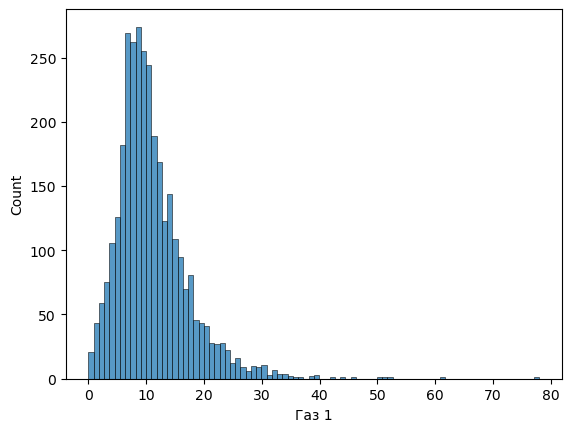

In [120]:
sns.histplot(data_gas_new,x='Газ 1')
plt.show()

### 1.4 data_temp_new

In [122]:
try:
  data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
except:
  data_temp_new = pd.read_csv(r'D:\data_set\project\data_temp_new.csv')

data_temp_new.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [123]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Целевая таблица, по условию заказчика модель должна предсказывать финальную температуру.Но нужно утонить,будет ли заказчик использовать модель только для финальной температуры или все же на промежуточных этапах тоже.Потому как,если только для финальной,то использование в качестве признака температуры до финальной значительно повысит точность модели,классическое:"лучший предиктор цены на завтра,цена сегодня".Но если модель все же будет использовать и на промежуточных этапах,то использовать такой дополнительный признака не корректно.Для начала выделим целевой признак - последня температура и предпоследнюю или же среднюю посмотрим,какой и них более близок к целевому.

In [124]:
data_temp_new['Время замера'] = data_temp_new['Время замера'].apply(pd.to_datetime)
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [125]:
data_temp_new.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

Имеются пропуску,если пропуск в финальном замере,то такой ковш лучше удалить.Для начала проверим данные на адекватность 

In [126]:
temp_diff = data_temp_new.groupby('key')['Время замера'].agg( lambda x: max(x) - min(x))
temp_diff = temp_diff.dt.total_seconds()
(temp_diff<0).sum()

0

Перепутанных данных нет,что хорошо.

In [127]:
data_temp_new['max_time'] = data_temp_new.groupby('key')['Время замера'].transform('max')
# количество пропусков в финальных замерах 
mask =   data_temp_new['Время замера'] == data_temp_new['max_time']
last_na = data_temp_new[mask]['Температура'].isna()
# номера ковшей с пропусками 
value = data_temp_new.loc[last_na[last_na == 1].index,'key'].values

# находим все индексы ковшей с пропусками в последнем замере 
indices = np.where(np.in1d(data_temp_new['key'].values,value))[0]
#удаляем
data_temp_new = data_temp_new.drop(indices)
# проверяем 
data_temp_new.tail(30)


,key,Время замера,Температура,max_time
13896,2494,2019-08-10 11:03:13,1592.0,2019-08-10 11:14:57
13897,2494,2019-08-10 11:09:50,1591.0,2019-08-10 11:14:57
13898,2494,2019-08-10 11:14:57,1591.0,2019-08-10 11:14:57
13899,2495,2019-08-10 11:27:47,1570.0,2019-08-10 11:50:47
13900,2495,2019-08-10 11:33:05,1590.0,2019-08-10 11:50:47
13901,2495,2019-08-10 11:38:43,1580.0,2019-08-10 11:50:47
13902,2495,2019-08-10 11:46:16,1585.0,2019-08-10 11:50:47
13903,2495,2019-08-10 11:50:47,1591.0,2019-08-10 11:50:47
13904,2496,2019-08-10 11:56:48,1554.0,2019-08-10 12:25:13
13905,2496,2019-08-10 12:00:52,1576.0,2019-08-10 12:25:13


In [128]:
# как позже выяснилось есть ковши,которые содержат одну запись,использовать их не корректно,
# так как они не отвечают требованием тех. процесса,с замером "до и после"
#найдем их и удалим сразу
wrong_key = data_temp_new[~data_temp_new['key'].duplicated(keep=False)].index
data_temp_new  = data_temp_new.drop(wrong_key)

In [129]:
# целевая переменная 
mask =   data_temp_new['Время замера'] == data_temp_new['max_time']
target_df  = data_temp_new.loc[mask,['Температура','key']]
#target_df = target_df.set_index('key')

In [130]:
target_df

,Температура,key
5,1613.0,1
10,1602.0,2
16,1599.0,3
21,1625.0,4
26,1602.0,5
...,...,...
13903,1591.0,2495
13910,1591.0,2496
13914,1589.0,2497
13920,1594.0,2498


In [131]:
# пробуем использовать признак как среднюю по ковшу до целевой 
temp_features = data_temp_new.loc[~mask,['Температура','key']]
temp_features = temp_features.groupby('key')['Температура'].mean().round()
temp_features


key
1       1600.0
2       1588.0
3       1598.0
4       1615.0
5       1586.0
         ...  
2495    1581.0
2496    1579.0
2497    1575.0
2498    1583.0
2499    1588.0
Name: Температура, Length: 2475, dtype: float64

####  Получаем значение первого замера 

In [137]:
first_measurement  = data_temp_new.loc[~mask,['Температура','key','Время замера']]
first_measurement['first']  = first_measurement.groupby('key')['Время замера'].transform('min')
mask = first_measurement['Время замера']  == first_measurement['first']
first_measurement = first_measurement.loc[mask,['Температура','key']]
first_measurement['first_temp'] = first_measurement['Температура']
first_measurement = first_measurement.drop(columns ='Температура' )
first_measurement

,key,first_temp
0,1,1571.0
6,2,1581.0
11,3,1596.0
17,4,1601.0
22,5,1576.0
...,...,...
13899,2495,1570.0
13904,2496,1554.0
13911,2497,1571.0
13915,2498,1591.0


In [138]:
first_measurement

,key,first_temp
0,1,1571.0
6,2,1581.0
11,3,1596.0
17,4,1601.0
22,5,1576.0
...,...,...
13899,2495,1570.0
13904,2496,1554.0
13911,2497,1571.0
13915,2498,1591.0


In [140]:
target_df.set_index

<bound method DataFrame.set_index of        Температура   key
5           1613.0     1
10          1602.0     2
16          1599.0     3
21          1625.0     4
26          1602.0     5
...            ...   ...
13903       1591.0  2495
13910       1591.0  2496
13914       1589.0  2497
13920       1594.0  2498
13925       1603.0  2499

[2475 rows x 2 columns]>

Как мы видим,ошибка по предыдущему значению,меньше чем по среднему.Если булем использовать эту фичу,то будем использовать именно предыдущий замер от финального.Так же еще одним преимуществом финального замера будет то,что да же,если в ковше одна итерацияи среднее нельзя посчитать,то одни замер точно будет. 

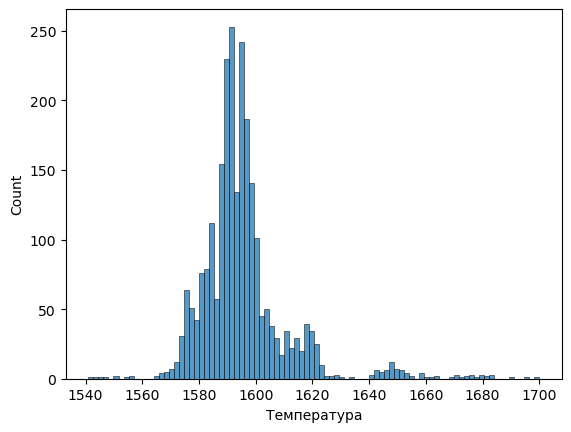

In [141]:


sns.histplot(target_df,x='Температура')
plt.show()

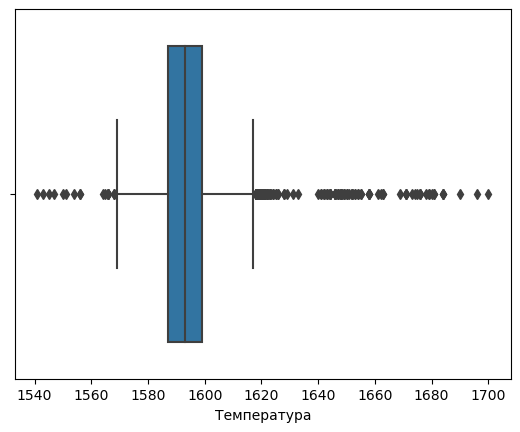

In [142]:
sns.boxplot(x='Температура', data=target_df) 
plt.show()

Целевую трогать не стоит,что бы не вышло,так что мы приняли реальные технологические параметры за выбросы и на  метриках,были бы хорошие показатели, в реальном процессе,на выпадающих значениях, модель бы ошибалась довольно сильно.

### 1.5 data_wire_new & data_wire_time_new 

In [143]:
try:
  data_wire_time_new  = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
  data_wire_time_new  = pd.read_csv(r'D:\data_set\project\data_wire_time_new.csv')

data_wire_time_new.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Время подачи  проволочных материалов не приносит никакой дополнительной информации, поэтому можно ее исключить.

In [144]:
try:
  data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
except:
  data_wire_new = pd.read_csv(r'C:\Users\Бегущий за пивом\Documents\шпаргалки\финальный проект\data_wire_new.csv')

data_wire_new.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


в Wire 5 одно значение,поэтому можно удалить 

In [146]:
data_wire_new = data_wire_new.drop(columns='Wire 5')

In [147]:
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,180.454575,32.847674,102.762401,90.053604


Посмотрим на распределение значений.

In [148]:
columns = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7',
       'Wire 8', 'Wire 9']

In [149]:
fig = make_subplots(rows=2, cols=4)

for i, col in enumerate(columns):
    fig.add_trace(
        go.Histogram(x=data_wire_new[col], name=col),
        row=int(i/4)+1, col=i%4+1
    )
  
fig.update_layout(
  title_text='Гистограммы проволочных материалов')
fig.show()

Можно поработать, только с wire_1 и wire_2, где присутствуют экстремальные значения.Опять же нужно уточнить,не является ли это "нормой" в процессе. Для других проволочных материалом,слишком мало информации.

### 1.6 Соединение таблиц в одну.

In [150]:
df_list =[
data_gas_new,
data_bulk_new,
data_arc_group,
data_wire_new
]


Перед тем как соединить таблицы,заполним нулями данные о подаче сыпучих материалов и данные о проволочных материалах.

In [151]:
data_wire_new.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [152]:

data_wire_new = data_wire_new.fillna(0)
print(
data_wire_new.isna().sum())

data_bulk_new = data_bulk_new.fillna(0)
print(data_bulk_new.isna().sum())

key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64
key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64


In [153]:
target_df['target_t']  = target_df['Температура'] 
target_df = target_df.drop(columns='Температура')
target_df 

features_df  = target_df

df_list =[first_measurement,
data_gas_new,
data_bulk_new,
data_arc_group,
data_wire_new
]

for df in df_list:
    features_df = features_df.merge(df,on = 'key',how='inner')
features_df

,key,target_t,first_temp,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Активная мощность,Реактивная мощность,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1613.0,1571.0,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,...,3.036730,2.142821,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1602.0,1581.0,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,...,2.139408,1.453357,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1599.0,1596.0,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,...,4.063641,2.937457,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1625.0,1601.0,18.841219,0.0,0.0,0.0,81.0,0.0,0.0,...,2.706489,2.056992,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1602.0,1576.0,5.413692,0.0,0.0,0.0,78.0,0.0,0.0,...,2.252950,1.687991,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1591.0,1570.0,7.125735,0.0,0.0,21.0,0.0,0.0,0.0,...,3.168133,2.210936,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2325,2496,1591.0,1554.0,9.412616,0.0,0.0,0.0,63.0,0.0,0.0,...,4.174918,2.872031,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2326,2497,1589.0,1571.0,6.271699,0.0,0.0,0.0,85.0,0.0,0.0,...,3.605239,2.452092,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2327,2498,1594.0,1591.0,14.953657,0.0,0.0,90.0,0.0,0.0,0.0,...,3.202310,2.239820,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:

features_df.isna().sum()

key                    0
target_t               0
first_temp             0
Газ 1                  0
Bulk 1                 0
Bulk 2                 0
Bulk 3                 0
Bulk 4                 0
Bulk 5                 0
Bulk 6                 0
Bulk 7                 0
Bulk 9                 0
Bulk 10                0
Bulk 11                0
Bulk 12                0
Bulk 13                0
Bulk 14                0
Bulk 15                0
full_power             0
physical_work          0
heating_duration       0
Активная мощность      0
Реактивная мощность    0
Wire 1                 0
Wire 2                 0
Wire 3                 0
Wire 4                 0
Wire 6                 0
Wire 7                 0
Wire 8                 0
Wire 9                 0
dtype: int64

In [155]:
features_df = features_df.fillna(0)

In [156]:
corr = round(features_df.corr(),3)
corr.style.background_gradient(cmap='coolwarm')

,key,target_t,first_temp,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,full_power,physical_work,heating_duration,Активная мощность,Реактивная мощность,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
key,1.000000,-0.097000,-0.019000,-0.043000,-0.078000,-0.006000,-0.007000,-0.026000,0.035000,0.006000,0.052000,-0.040000,0.063000,0.035000,0.026000,-0.016000,-0.110000,-0.046000,-0.024000,-0.025000,-0.038000,-0.025000,-0.023000,-0.014000,0.043000,-0.027000,0.049000,-0.008000,0.037000,-0.036000,0.021000
target_t,-0.097000,1.000000,0.252000,0.059000,-0.075000,-0.082000,-0.036000,0.188000,-0.028000,-0.182000,-0.107000,-0.016000,0.061000,-0.115000,0.267000,-0.011000,0.115000,0.266000,0.153000,0.212000,0.231000,0.155000,0.150000,0.318000,-0.207000,-0.048000,-0.160000,-0.084000,-0.137000,-0.011000,-0.027000
first_temp,-0.019000,0.252000,1.000000,0.037000,0.072000,0.120000,-0.104000,0.145000,0.068000,-0.097000,0.075000,-0.026000,0.035000,-0.088000,-0.058000,0.019000,-0.131000,-0.040000,-0.099000,-0.243000,-0.272000,-0.099000,-0.100000,0.209000,-0.086000,-0.000000,0.065000,0.020000,0.045000,-0.023000,0.004000
Газ 1,-0.043000,0.059000,0.037000,1.000000,0.234000,0.217000,0.060000,0.018000,0.087000,0.140000,0.198000,0.117000,-0.009000,0.042000,0.217000,0.049000,0.269000,0.044000,0.344000,0.307000,0.338000,0.344000,0.342000,0.117000,0.104000,0.103000,0.145000,0.108000,0.079000,0.118000,0.014000
Bulk 1,-0.078000,-0.075000,0.072000,0.234000,1.000000,0.225000,-0.012000,0.042000,0.060000,-0.004000,0.237000,-0.020000,-0.023000,-0.038000,0.326000,-0.010000,0.208000,-0.001000,0.096000,0.095000,0.102000,0.097000,0.093000,0.014000,-0.009000,0.020000,0.146000,0.149000,0.083000,-0.020000,0.011000
Bulk 2,-0.006000,-0.082000,0.120000,0.217000,0.225000,1.000000,-0.047000,0.041000,0.360000,-0.030000,0.679000,-0.005000,-0.018000,0.001000,-0.099000,-0.006000,-0.141000,-0.106000,0.090000,0.038000,0.034000,0.091000,0.087000,-0.169000,-0.039000,0.223000,0.699000,0.559000,0.432000,-0.005000,-0.007000
Bulk 3,-0.007000,-0.036000,-0.104000,0.060000,-0.012000,-0.047000,1.000000,-0.295000,-0.007000,0.065000,-0.033000,0.011000,-0.085000,-0.007000,0.018000,-0.013000,0.011000,-0.013000,0.097000,0.086000,0.093000,0.098000,0.095000,0.040000,0.096000,0.006000,-0.041000,0.007000,-0.019000,0.005000,0.005000
Bulk 4,-0.026000,0.188000,0.145000,0.018000,0.042000,0.041000,-0.295000,1.000000,0.028000,-0.252000,0.046000,-0.003000,-0.085000,-0.120000,0.106000,0.003000,-0.091000,0.102000,0.016000,0.004000,-0.004000,0.017000,0.016000,0.298000,-0.268000,-0.039000,0.034000,-0.011000,0.034000,0.008000,-0.058000
Bulk 5,0.035000,-0.028000,0.068000,0.087000,0.060000,0.360000,-0.007000,0.028000,1.000000,-0.022000,0.288000,-0.008000,-0.028000,-0.016000,-0.073000,-0.009000,-0.066000,-0.067000,0.080000,0.035000,0.029000,0.080000,0.079000,-0.013000,-0.014000,0.071000,0.263000,0.205000,0.172000,-0.008000,-0.011000
Bulk 6,0.006000,-0.182000,-0.097000,0.140000,-0.004000,-0.030000,0.065000,-0.252000,-0.022000,1.000000,-0.025000,-0.029000,-0.097000,0.197000,-0.113000,0.043000,0.177000,-0.109000,0.123000,0.128000,0.140000,0.123000,0.122000,-0.236000,0.205000,-0.047000,-0.026000,-0.020000,-0.012000,-0.028000,-0.013000


 Для построения модели,как видно самый важный признак это предыдущая температура.Так же мы можем удалить Bulk 9,так он линейно зависим с Wire 8.И для обучения модели мы будем использовать только физическую работу,вместо мощности и времени нагрева. Подготовим данные для модели,посмотри на результат,возможно попробуем признаки.

In [157]:
features_df.columns

Index(['key', 'target_t', 'first_temp', 'Газ 1', 'Bulk 1', 'Bulk 2', 'Bulk 3',
       'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 9', 'Bulk 10', 'Bulk 11',
       'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'full_power',
       'physical_work', 'heating_duration', 'Активная мощность',
       'Реактивная мощность', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [158]:
# удаляем не нужные признаки 
features_df  = features_df.drop(columns=['key','Bulk 9','full_power','heating_duration','Активная мощность','Реактивная мощность'])


## План :

1. Провести EDA
   
2. Масштабировать  данные
3. Провести подбор модели  гипперпараметров
4. В зависимости от результатов,либо оставить так,либо попробовать с другими признаками,другой обработкой данных
5. Интерпретировать результат 
6. Дать рекомендации

Вопросы:
1. Важен ли порядок в котором в ковш подаются сыпучии материалы?
2. Насколько корректно убирать экстремальные значения для: для сыпучих материалов,проволоки,газа и температуры?
3. Можно ли использовать предфинльное значение температуры в качестве признака?

# 2.0 Обучение моделей 

Поскольку у нас некоторые признаки достаточно разряженные,поэтому будем использовать масштабирование данных с использованием MaxAbsScaler

Но сначала подготовим данные


In [159]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

target_df  = target_df.drop(c)

In [160]:
target = features_df['target_t']
features_df = features_df.drop(columns='target_t')

In [161]:


#тестовая и обучающая 
features_train, features_test, target_train, target_test = train_test_split(
    features_df, target, test_size=0.25, random_state=RANDOM_STATE)




# для кросс валидации 
features_train_cross = features_train.copy()
target_train_cross = target_train.copy()



In [162]:
# масштабируем признаки 
scaler = StandardScaler()

features_train_cross = scaler.fit_transform(features_train_cross)

features_test = scaler.transform(features_test)


### 2.1 Линейная регрессия

In [163]:

# обучим линейную регрессию 
reg_model = LinearRegression() 

scores = -cross_val_score(reg_model, features_train_cross,target_train, scoring='neg_mean_absolute_error', cv=5)

#mae_reg_model = mean_absolute_error(target_valid, predictions)
print('Абсолютная ошибка линейной регрессии:',round(scores.mean()))

Абсолютная ошибка линейной регрессии: 7


К сожалению,модель не прошла порог.

### 2.2 LightGBM 

In [165]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

In [166]:
%%time

# создадим модель LightGBM для задачи регрессии:
random_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

# создадим словарь с гиперпараметрами для модели:
parameters = { 'metric': ['mae'],
              'boosting_type': ['gbdt'], 
              'n_estimators': range(150,250,5),
              'max_depth': range(8,10,1) } 


# подберём гиперпараметры с помощью RandomizedSearchCV
random_lgbm_result = RandomizedSearchCV(random_lgbm, parameters,scoring='neg_mean_absolute_error', cv=5, verbose=3)

# обучим модель
random_lgbm_result.fit(features_train_cross,target_train_cross)

# получим предсказания
predictions = random_lgbm_result.predict(features_train_cross)


print('MAE наилучшей модели LightGBM c RandomizedSearchCV:', f'{abs(random_lgbm_result.best_score_):.2f}')
print('Наилучшая модель LightGBM c RandomizedSearchCV:', random_lgbm_result.best_estimator_)
print('Параметры наилучшей модели LightGBM c RandomizedSearchCV:', random_lgbm_result.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END boosting_type=gbdt, max_depth=9, metric=mae, n_estimators=240;, score=-7.471 total time=   0.4s
[CV 2/5] END boosting_type=gbdt, max_depth=9, metric=mae, n_estimators=240;, score=-7.317 total time=   0.3s
[CV 3/5] END boosting_type=gbdt, max_depth=9, metric=mae, n_estimators=240;, score=-7.247 total time=   0.1s
[CV 4/5] END boosting_type=gbdt, max_depth=9, metric=mae, n_estimators=240;, score=-7.443 total time=   0.1s
[CV 5/5] END boosting_type=gbdt, max_depth=9, metric=mae, n_estimators=240;, score=-6.262 total time=   0.1s
[CV 1/5] END boosting_type=gbdt, max_depth=8, metric=mae, n_estimators=190;, score=-7.384 total time=   0.2s
[CV 2/5] END boosting_type=gbdt, max_depth=8, metric=mae, n_estimators=190;, score=-7.321 total time=   0.0s
[CV 3/5] END boosting_type=gbdt, max_depth=8, metric=mae, n_estimators=190;, score=-7.137 total time=   0.0s
[CV 4/5] END boosting_type=gbdt, max_depth=8, metric=mae, n_estimat

* MAE наилучшей модели LightGBM c RandomizedSearchCV: 7.07
* Наилучшая модель LightGBM c RandomizedSearchCV: LGBMRegressor(max_depth=8, metric='mae', n_estimators=150, random_state=30723)
* Параметры наилучшей модели LightGBM c RandomizedSearchCV: {'n_estimators': 150, 'metric': 'mae', 'max_depth': 8, 'boosting_type': 'gbdt'}
Wall time: 12.1 s

### 2.3 Catboost

In [168]:
from catboost import CatBoostRegressor 

In [170]:
%%time


# создадим модель CatBoost 
random_cat = CatBoostRegressor(
    random_seed=RANDOM_STATE,
    learning_rate=0.075,
    early_stopping_rounds=10, 
    l2_leaf_reg=4, 
    eval_metric = 'MAE'

)
#
#  словарь с гиперпараметрами 
parameters  = {
    'iterations':[139], 
    'depth': [7],
}

# подберём гиперпараметры с помощью RandomizedSearchCV:
random_cat_result = RandomizedSearchCV(random_cat, parameters,scoring='neg_mean_absolute_error',  cv=3, n_jobs=-1)

# обучим модель:
random_cat_result.fit(features_train_cross, target_train_cross)

# получим предсказания:
predictions = random_cat_result.predict(features_train_cross)


print('MAE наилучшей модели CatBoost c RandomizedSearchCV:', f'{abs(random_cat_result.best_score_):.2f}')
print('Наилучшая модель CatBoost c RandomizedSearchCV:', random_cat_result.best_estimator_)
print('Параметры наилучшей модели CatBoost c RandomizedSearchCV:', random_cat_result.best_params_)

0:	learn: 7.9610610	total: 8.82ms	remaining: 1.22s
1:	learn: 7.8388463	total: 20.2ms	remaining: 1.38s
2:	learn: 7.7185668	total: 27.1ms	remaining: 1.23s
3:	learn: 7.6090985	total: 34.6ms	remaining: 1.17s
4:	learn: 7.5353245	total: 40.5ms	remaining: 1.09s
5:	learn: 7.4741977	total: 48.6ms	remaining: 1.08s
6:	learn: 7.4063070	total: 55.2ms	remaining: 1.04s
7:	learn: 7.3363841	total: 62.6ms	remaining: 1.02s
8:	learn: 7.2585571	total: 68.9ms	remaining: 995ms
9:	learn: 7.2013103	total: 76.8ms	remaining: 990ms
10:	learn: 7.1480830	total: 83.2ms	remaining: 969ms
11:	learn: 7.0986055	total: 89.8ms	remaining: 951ms
12:	learn: 7.0520075	total: 98.7ms	remaining: 956ms
13:	learn: 7.0108076	total: 107ms	remaining: 960ms
14:	learn: 6.9799874	total: 113ms	remaining: 935ms
15:	learn: 6.9315724	total: 119ms	remaining: 914ms
16:	learn: 6.9011469	total: 126ms	remaining: 903ms
17:	learn: 6.8637512	total: 132ms	remaining: 886ms
18:	learn: 6.8312473	total: 138ms	remaining: 871ms
19:	learn: 6.8053834	total: 

* MAE наилучшей модели CatBoost c RandomizedSearchCV: 6.71
* Наилучшая модель CatBoost c RandomizedSearchCV: <catboost.core.CatBoostRegressor object at 0x0000022526A43A90>
* Параметры наилучшей модели CatBoost c RandomizedSearchCV: {'iterations': 139, 'depth': 7}
* Wall time: 25 s

In [172]:
best_model = random_cat_result.best_estimator_


Исходя из результатов,наиболее меньшую ошибку дает модель CatBoost,именно ее протестируем на адекватность на тестовой выборке.

### 2.4 Результат на тестовой выборке 

In [173]:
# предсказание модели на тестовой выборке 
predictions = best_model.predict(features_test)

mae_catboost_test  = mean_absolute_error(target_test, predictions)

print('MAE модели Catboost на тестовой выборке :', f'{mae_catboost_test:.2f}')


MAE модели Catboost на тестовой выборке : 6.57


Очень хороший результат,значит наша модель не переобучилась и ее можно использовать в промышленности 


# 3.0 Интерпретация модели с использованием Shap  

Легко интерпретировать модель лииной регрессии,но что делать с моделях основанных на деревьях? На помощь приходит библиотека SHAP.В библиотеке SHAP для оценки важности фичей рассчитываются значения Шэпли (по имени американского математика и названа библиотека). 



Формула для расчета значения Шэпли для i-той фичи:
$
{\displaystyle \Phi (p)_{i}=\sum _{S\in N\setminus i}{\frac {|S|!(n -|S| - 1 )!}{n!}}\left(p(S)-p(S\setminus i)\right)}
$



$
p(S) 
$- то предсказание модели с i-той фичей



$p(S\setminus i)$  -это предсказание модели без i-той фичи


$n$ - количество фич


$S$ - произвольный набор фичей без i-той фичи




*значение Шепли* = ожидаемый  вклад  или взвешенное среднее по вкладу каждой фичи.
В общем смысле,значение Шепли можно интерпретировать,как ожидаем  вклад фичи в предсказание, умноженный на вероятность что этот вклад будет сделан,взятый как сумма во всех возможных сочетаниях фичей.Плюсы значения Шепли  - учитывает как индивидуальный вклад каждого признака, так взаимодействие признаков


In [174]:
#дадим имена фичам 
df = pd.DataFrame(features_test, columns = features_df.columns)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


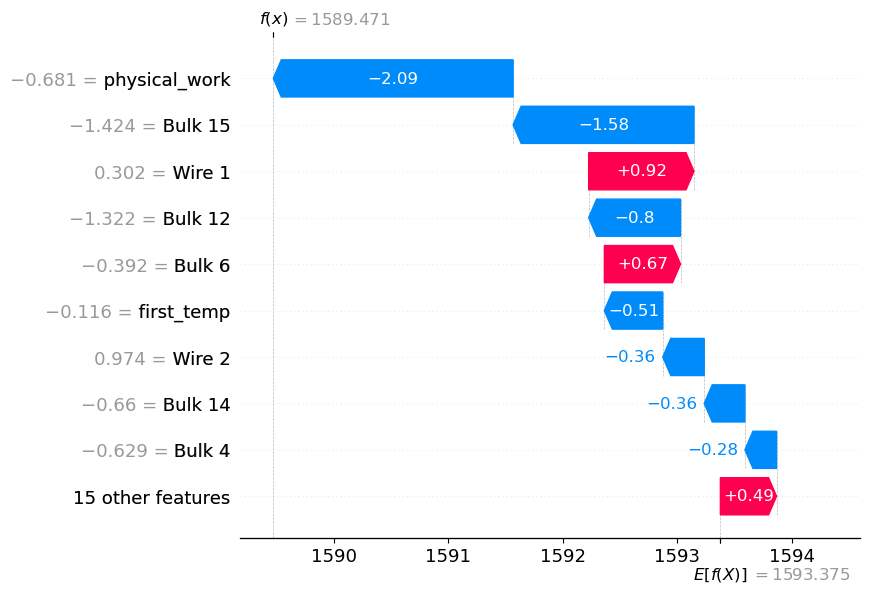

In [175]:
# импортруем 
import shap

#создаем объект и наполняем значениям 
explainer = shap.Explainer(best_model)
shap_values = explainer(df)

# выведем первый график по первому ковшу в списке 
shap.plots.waterfall(shap_values[0])

$E[f(x)]$ = 1593 - среднее предсказание по всему датасету 


$f(x)$ - 1589 предсказание по конкретному ковшу 


график показывает разницу между средним предсказание по датасету и конкретному наблюдению. Самый большой вклад по этому ковшу вносит совершёная работа,точнее ее меньшее значение по сравнению со средним по выборке и она отнимает -2.09 градуса,за ним уменьшает температуру добавление bulk 15 -1.58, 
а вот добавление  *wire1* поднимает предсказание по температуре  на +0,92 и т.д.

Динамику вкладов по определенному срезу данных,можно посмотреть в интерактивном графике ниже.

In [ ]:
shap.initjs()

shap.plots.force(shap_values[0:50])

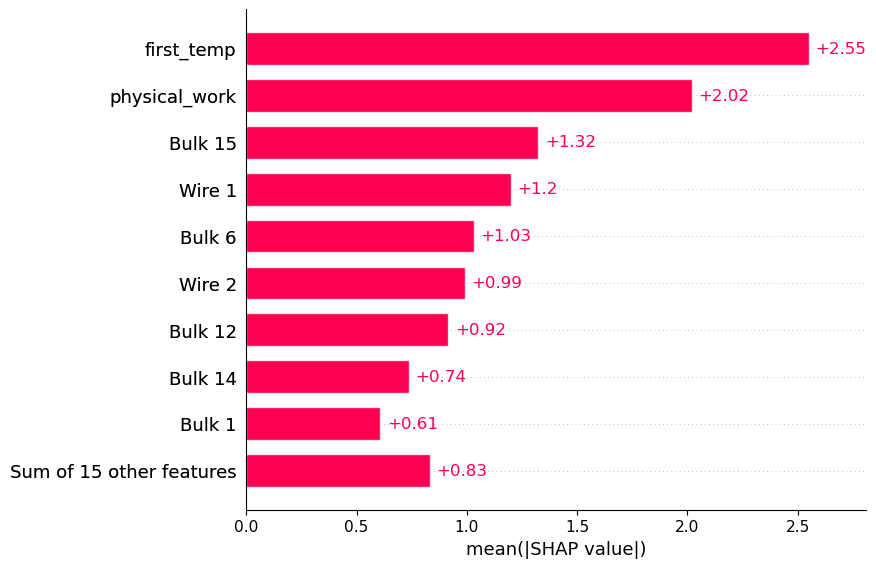

In [176]:
# график для абсолютного вклада каждой фичи
shap.plots.bar(shap_values)

Здесь представлены вклад в предсказание температуры по признакам.Взято среднее абсолютное значение по каждому признаку. Чем больше вклад,тем больше значение.Не удивительно,что наибольший вклад вносит, первый замер температуры,за ним идет, совершенная работа для подогрева.После добавление проволочных материалов bulk15,wire1 и т.д. 

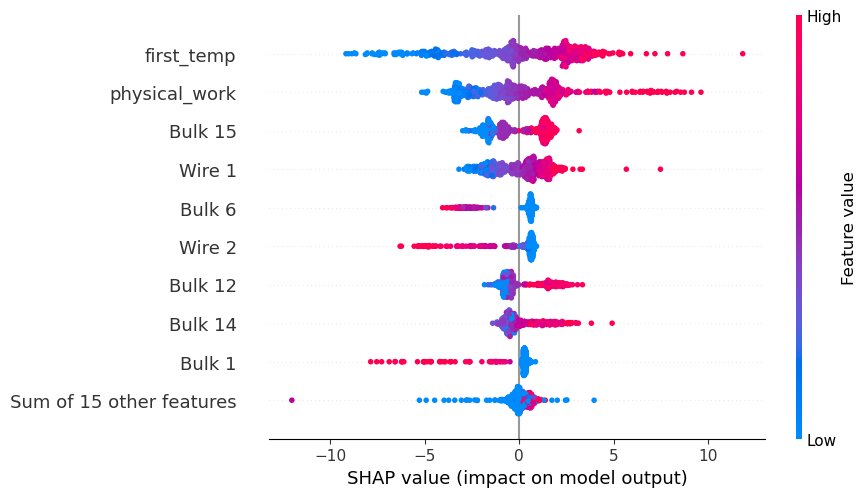

In [177]:
shap.plots.beeswarm(shap_values)

На данном графике представлено влияние каждого фактора в динамике.Увеличение первого замера температуры приводить приводит к увеличению температуры предсказания.Также с совершенной работой.Аналогично wire1 и bulk15,но иначе для wire2 и bulk6,при увеличении проволочных и сыпучих материалов,происходит уменьшение температуры предсказаний смеси и т.д. 

Посмотрим на некоторые значения в топе,как связано их количество и вклад в предсказание.

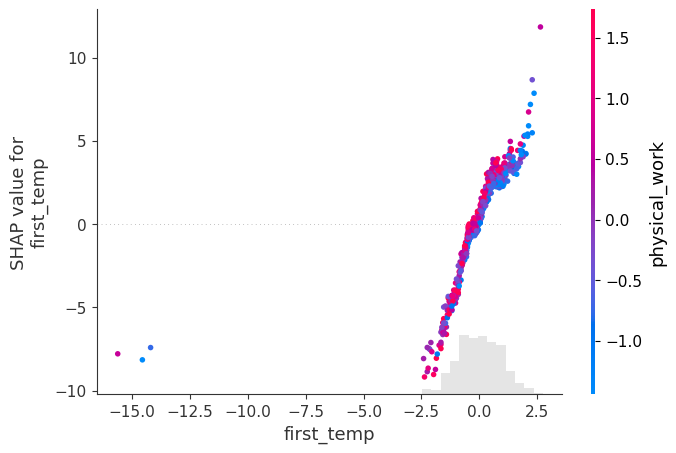

In [179]:
# для температуры и физической работы 
shap.plots.scatter(shap_values[:,'first_temp'],
                   color = shap_values[:,'physical_work'])

На графике почти линейная связь,за исключением выбросов вначале.Также более низкое значения первого замера температуры связаны с большей совершенной работой,что не удивительно.

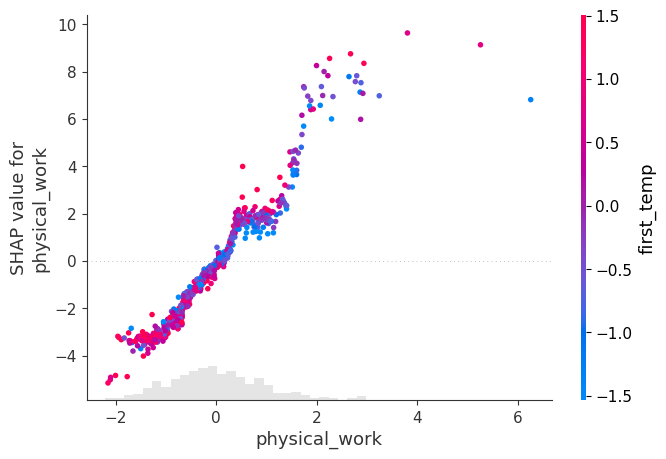

In [180]:
shap.plots.scatter(shap_values[:,'physical_work'],
                   color =shap_values[:,'first_temp'])

Аналогично и для совершенной работы,только угол наклона больше.В общем случае можно сказать,что чем меньше начальная температура,тем с большей вероятностью будет более весомый вклад совершенной работы в предсказанную температуру 

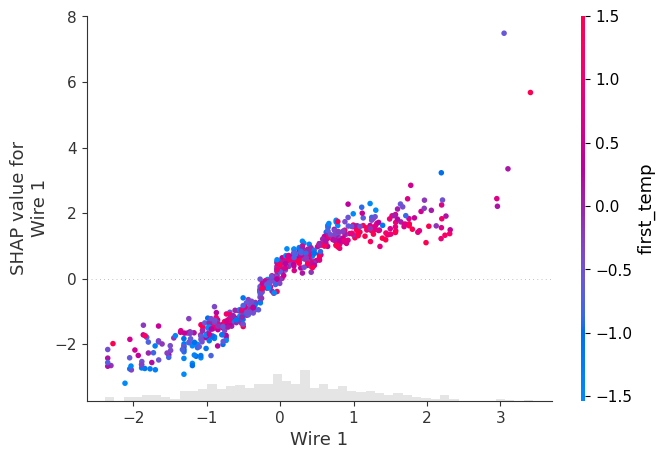

In [182]:
shap.plots.scatter(shap_values[:,'Wire 1'],
                   color=shap_values[:,'first_temp'])


График можно аппроксимировать прямой,зависимость линейная,чем больше значение wire1 тем больше вклад предсказанное значение температуры.

Была проведена работа первичная обработка данных:

1. Выгрузили датафреймы:
    1.  В таблице с потребляемой мощностью и продолжительностью нагрева,мы сначала перешли от активной и реактивной к полной мощности,а затем к работе,чтобы улучшить предсказательную силу модели
    2. выгрузили таблицу для сыпучих материалов,посмотрели на распределение,оставили только ключевые признаки с объемом материала
    3. выгрузили таблицу подачи газа,проверили на пропуски,избавились от аномальных переменных
    4. выгрузили ключевую таблицу со значением температуры по каждому ковшу,избавились от ковшей с аномальными значениями,пропусками в целевой переменной.Также добавили признак - первый замер температуры ковша.
    5. Выгрузили данные о проволочных материалах,проверили на аномалии и пропуски. 
    6. Наибольшие трудности были вызваны в попытке понять,что цифры значат,гораздо легче работать со значением,если за ними стоит воплощенный смысл 
   


2.  Объединили все таблицы в один датафрейм по ключу с помощью метода 'inner',чтобы оставить только значения без пропусков в ковшах
    1. проверили датафрейм на пропуски,отсутствующие значения для объема материалов заполнили нулями 
    2.  произвели проверку на мультиколлинеарность,удалили столбец bulk9,так же оставили признаки необходимые для обучения модели 
3. Разбили датафрейм на тестовую выборку и обучающую,размер теста = 0,25
4. Провели масштабирование признаков 
5. Обучили модели и провели подбор гипперпараметров 
    1. Линейная регрессия - МАЕ = 7 использовали именно эту модель первой,так как ее легко интерпретировать и можно использовать как некий базовой уровень.Однако она не прошла пороговое значение на  кроссвалидации 
    2. LightGBM МАЕ = 7,2 Использовал подбор гипперпараметров через рандомсерч,в разных итерациях модель не смогла прейти поставленные порог в МАЕ = 6,8
    3. Catboost МАЕ = 6,7 Параметры наилучшей модели CatBoost  ,сначала использовал рандомсерч,для примерного поиска наилучших параметров,затем более точно через грисерч,наилучшие показания были достигнуты при {'iterations': 139, 'depth': 7,learning_rate=0.075}. Именно эта модель стала лучшей.
 6. MAE модели Catboost на тестовой выборке : 6.57
 7. Интерпретация результатов важности признаков была произведена с помощью библиотеки SHAP.
*значение Шепли*  - взвешенное среднее по вкладу каждой фичи.
1. Наиболее важные признаки влияющие на *предсказанную* температуру:
   1. Первый замер температуры - 2.55
   2. Совершенная работа - 2.02
   3. Сыпучий материал bulk 15 - 1.32 
   4. Проволочный материал wire1 - 1.2
   5. Сыпучий материал bulk 6 - 1.03


Рекомендации, вторым по важности фактором является проделанная работа,это значит энергозатраты будут зависеть от продолжительности нагрева,так же от мощности,в целях экономии можно посмотреть в сторону снижения  паразитной, реактивной мощности или же уменьшения времени нагрева,возможно за счет других более теплопроводных электродов и тд.Так же обратить внимание на сыпучие материалы bulk15 и bulk6 и конечно,на проволочный wire1.Не исключена возможность взаимодействия факторов.И поскольку главный фактор - начальная температура ковша,то по возможности использовать более точные и быстродействующие измерительные приборы.Главное помнить -  модель не показывает,как важны факторы в реальной жизни,он показывает  важность факторов для самой модели. Без эмпирики и проверки гипотез,факторы останутся сырыми цифрами в модели